In [9]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from itertools import product
import random
import sklearn.metrics
from scipy.stats import pearsonr

%matplotlib inline

In [27]:
# load data
data_set_name = "promoter_1"
epoch_name = "19"

nat_seq_name = "data/" + data_set_name + ".npy"
syn_seq_name = "syn_seq/" + data_set_name +"/seq_epoch_{}.npy".format(epoch_name)

nat_seq = np.load(nat_seq_name)
nat_seq = nat_seq.tolist()

syn_seq = np.load(syn_seq_name)
syn_seq = syn_seq.tolist()


In [2]:
# extract k-mers
def get_k_mers(sequences, k):
    list = []
    # 先遍历所有seq并提取所有子序列，得到len(sequences)*len(sequences[i])-k+1个k_mers
    for i in range(len(sequences)):
        for j in range(len(sequences[i])-k+1):
            list.append(sequences[i][j:j+k])
    return list

In [3]:
# get all k-mers
def nucleotide_type(k):
    z = []
    for i in product('ACGT', repeat = k):  #笛卡尔积（有放回抽样排列）
        z.append(''.join(i))  #把('A,A,A')转变成（AAA）形式
    return z

In [4]:
def fea(sequences, k):
    char = nucleotide_type(k)
    k_mers = get_k_mers(sequences, k)
    list = []
    for i in range(4**k):
        n = 0
        for k_mer in k_mers:
            if k_mer == char[i]:
                n += 1
        list.append(n)
    return list

In [5]:
def fre_fea(sequences, k):
    char = nucleotide_type(k)
    k_mers = get_k_mers(sequences, k)
    list = []
    for i in range(4**k):
        n = 0
        for k_mer in k_mers:
            if k_mer == char[i]:
                n += 1
        list.append(n/len(k_mers))
    return list

In [41]:
max_mer_len = 5
nat_k_mer_freq = [fea(nat_seq, i) for i in range(2, max_mer_len+1)]
syn_k_mer_freq = [fea(syn_seq, i) for i in range(2, max_mer_len+1)]

fea_dict_df = [pd.DataFrame({"nature": nat_k_mer_freq[i], "synthetic": syn_k_mer_freq[i]}) for i in range(max_mer_len-1)]


In [18]:
def count_k_mer(nat_seq_name, syn_seq_name, max_mer_len):
    nat_seq = np.load(nat_seq_name, allow_pickle=True)
    nat_seq = nat_seq.tolist()

    syn_seq = np.load(syn_seq_name, allow_pickle=True)
    syn_seq = syn_seq.tolist()

    nat_k_mer_freq = [fea(nat_seq, i) for i in range(2, max_mer_len+1)]
    syn_k_mer_freq = [fea(syn_seq, i) for i in range(2, max_mer_len+1)]

    fea_dict_df = [pd.DataFrame({"nature": nat_k_mer_freq[i], "synthetic": syn_k_mer_freq[i]}) for i in range(max_mer_len-1)]
    k_mer_r2_list = []

    for i in range(max_mer_len - 1):
        k_mer_r2_list.append(pearsonr(fea_dict_df[i]['nature'], fea_dict_df[i]['synthetic']))
    return k_mer_r2_list


In [11]:
k = 6
res = [[] for _ in range(k-1)]
for i in range(130):
    if i % 25 == 24:
        temp = count_k_mer("data/promoter_1.npy", "syn_seq/promoter_1/seq_epoch_{}.npy".format(i),6)
        for j in range(k-1):
            res[j].append(temp[j])

In [12]:
res_npy = np.array(res)
res_npy

array([[[8.82839283e-001, 5.92933859e-006],
        [9.59505148e-001, 4.30121271e-009],
        [8.46919917e-001, 3.48880010e-005],
        [9.61873732e-001, 2.83861061e-009],
        [9.27709316e-001, 2.28181436e-007]],

       [[9.08274764e-001, 3.81390144e-025],
        [9.34779389e-001, 1.45819343e-029],
        [8.79574552e-001, 1.13728455e-021],
        [9.55786892e-001, 1.16423848e-034],
        [9.36718658e-001, 5.88911147e-030]],

       [[9.05971850e-001, 8.32064548e-097],
        [9.17693072e-001, 8.11799040e-104],
        [8.86998452e-001, 3.27656211e-087],
        [9.48690865e-001, 5.17444601e-129],
        [9.35725794e-001, 5.99152044e-117]],

       [[8.79467432e-001, 0.00000000e+000],
        [8.89393351e-001, 0.00000000e+000],
        [8.72377237e-001, 6.00586199e-320],
        [9.24011288e-001, 0.00000000e+000],
        [9.19061015e-001, 0.00000000e+000]],

       [[8.12681111e-001, 0.00000000e+000],
        [8.29267868e-001, 0.00000000e+000],
        [8.25474742e-001

In [19]:
k = 6
gan_res_1 = [[] for _ in range(k-1)]
dif_res_1 = [[] for _ in range(k-1)]
for i in range(130):
    if i % 25 == 24:
        temp_gan = count_k_mer("data/promoter_1.npy", "gan_seq/promoter_1/seq_epoch_{}.npy".format(i),6)
        temp_dif = count_k_mer("data/promoter_1.npy", "syn_seq/promoter_1/seq_epoch_{}.npy".format(i),6)
        for j in range(k-1):
            gan_res_1[j].append(temp_gan[j])
            dif_res_1[j].append(temp_dif[j])

gan_res_2 = [[] for _ in range(k-1)]
dif_res_2 = [[] for _ in range(k-1)]
for i in range(130):
    if i % 25 == 24:
        temp_gan = count_k_mer("data/promoter_2.npy", "gan_seq/promoter_2/seq_epoch_{}.npy".format(i),6)
        temp_dif = count_k_mer("data/promoter_2.npy", "syn_seq/promoter_2/seq_epoch_{}.npy".format(i),6)
        for j in range(k-1):
            gan_res_2[j].append(temp_gan[j])
            dif_res_2[j].append(temp_dif[j])

gan_res_3 = [[] for _ in range(k-1)]
dif_res_3 = [[] for _ in range(k-1)]
for i in range(130):
    if i % 25 == 24:
        temp_gan = count_k_mer("data/promoter_3.npy", "gan_seq/promoter_3/seq_epoch_{}.npy".format(i),6)
        temp_dif = count_k_mer("data/promoter_3.npy", "syn_seq/promoter_3/seq_epoch_{}.npy".format(i),6)
        for j in range(k-1):
            gan_res_3[j].append(temp_gan[j])
            dif_res_3[j].append(temp_dif[j])

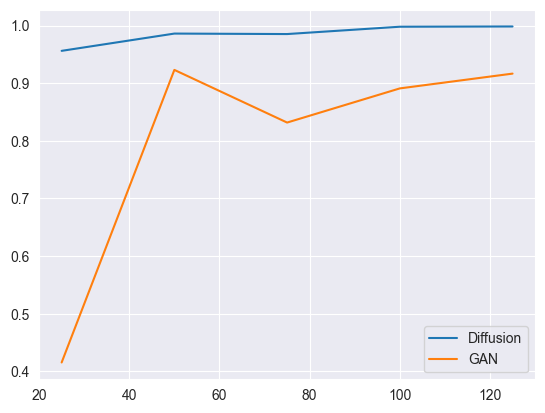

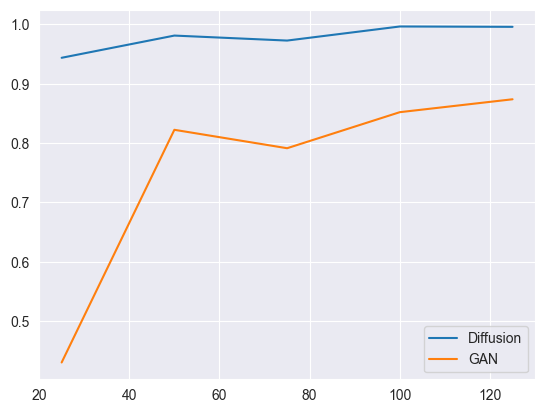

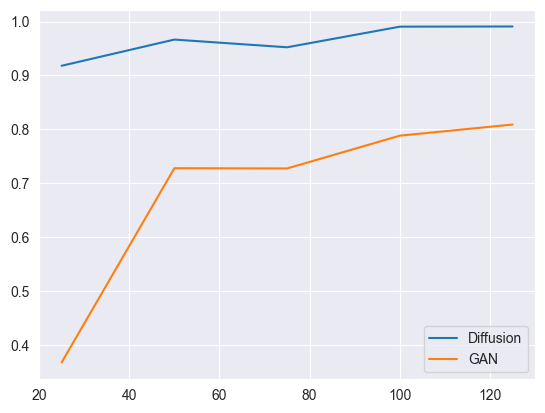

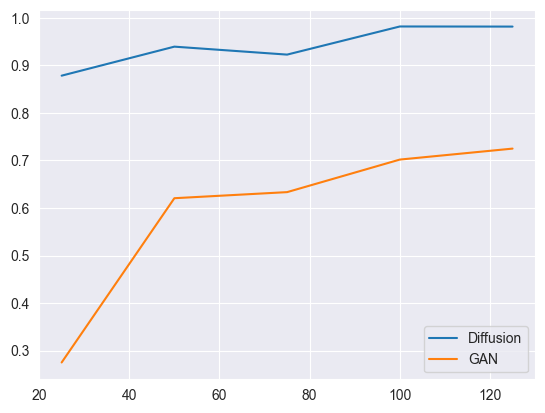

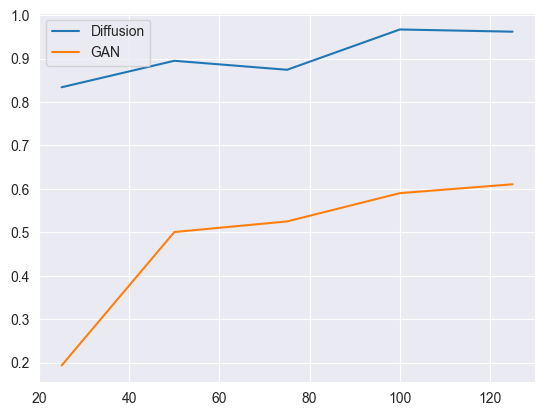

In [30]:
dif_res_3_list = []
gan_res_3_list = []
for i in range(k-1):
    temp_dif = []
    temp_gan = []
    for j in range(5):
        temp_dif.append(dif_res_3[i][j][0])
        temp_gan.append(gan_res_3[i][j][0])
    dif_res_3_list.append(temp_dif)
    gan_res_3_list.append(temp_gan)

dif_res_2_list = []
gan_res_2_list = []
for i in range(k-1):
    temp_dif = []
    temp_gan = []
    for j in range(5):
        temp_dif.append(dif_res_2[i][j][0])
        temp_gan.append(gan_res_2[i][j][0])
    dif_res_2_list.append(temp_dif)
    gan_res_2_list.append(temp_gan)

dif_res_1_list = []
gan_res_1_list = []
for i in range(k-1):
    temp_dif = []
    temp_gan = []
    for j in range(5):
        temp_dif.append(dif_res_1[i][j][0])
        temp_gan.append(gan_res_1[i][j][0])
    dif_res_1_list.append(temp_dif)
    gan_res_1_list.append(temp_gan)




In [41]:

a = pd.DataFrame(dif_res_3_list, columns = [25, 50, 75, 100, 125], index = [i+2 for i in range(5)])
a

,25,50,75,100,125
2,0.956089,0.986045,0.985212,0.997922,0.998355
3,0.943719,0.981155,0.972738,0.996488,0.995884
4,0.917988,0.966637,0.952330,0.990604,0.990950
5,0.878211,0.939232,0.922491,0.981644,0.981414
6,0.834090,0.895057,0.874346,0.967113,0.962062


In [45]:

a = pd.DataFrame(gan_res_3_list, columns = [25, 50, 75, 100, 125], index = [i+2 for i in range(5)])
a

,25,50,75,100,125
2,0.415557,0.923032,0.831707,0.890943,0.916593
3,0.430199,0.822346,0.791297,0.852058,0.873800
4,0.367283,0.727865,0.727428,0.788265,0.808935
5,0.275148,0.620550,0.633338,0.701775,0.724837
6,0.193541,0.500795,0.525199,0.590257,0.610700


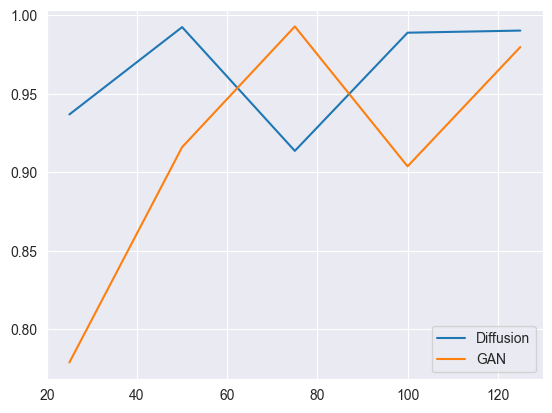

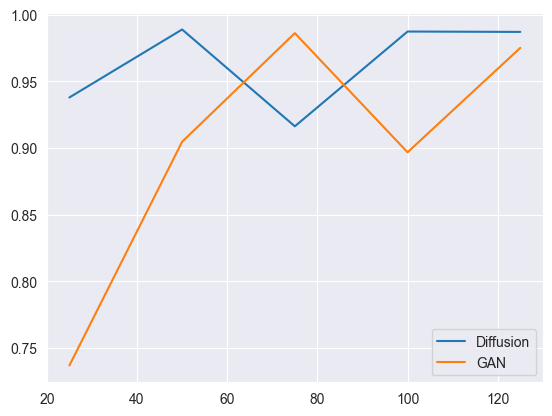

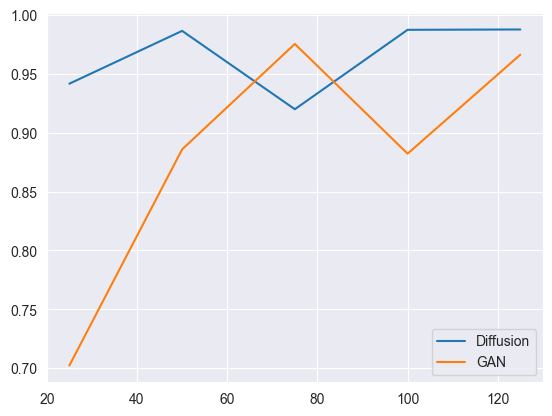

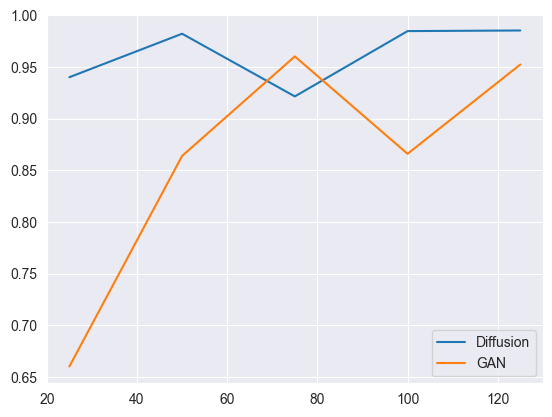

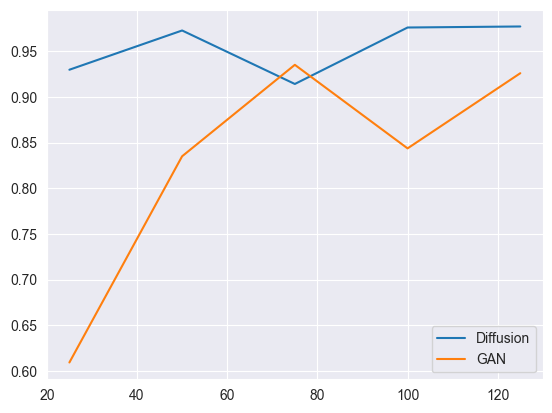

In [47]:
t = [25 * (i+1) for i in range(5)]
for i in range(k-1):
    plt.plot(t, dif_res_2_list[i], label='Diffusion')
    plt.plot(t, gan_res_2_list[i], label='GAN')
    plt.legend()
    plt.show()

In [54]:
dif_k_mer_table = []
gan_k_mer_table = []
k=6
for t in range(3):
    gan_temp = [[] for _ in range(k-1)]
    dif_temp = [[] for _ in range(k-1)]
    for i in range(130):
        if i % 10 == 9:
            temp_gan = count_k_mer("data/promoter_{}.npy".format(t+1), "gan_seq/promoter_{}/samples_{}.npy".format(t+1, i), 6)
            temp_dif = count_k_mer("data/promoter_{}.npy".format(t+1), "syn_seq/promoter_{}/new_seq_epoch_{}.npy".format(t+1, i), 6)
            for j in range(k-1):
                gan_temp[j].append(temp_gan[j])
                dif_temp[j].append(temp_dif[j])
    dif_k_mer_table.append(dif_temp)
    gan_k_mer_table.append(gan_temp)


In [61]:
dif_k_mer_list = []
gan_k_mer_list = []
for t in range(3):
    dif_k_mer_temp = []
    gan_k_mer_temp = []
    for i in range(k-1):
        temp_dif = []
        temp_gan = []
        for j in range(13):
            temp_dif.append(dif_k_mer_table[t][i][j][0])
            temp_gan.append(gan_k_mer_table[t][i][j][0])
        dif_k_mer_temp.append(temp_dif)
        gan_k_mer_temp.append(temp_gan)
    dif_k_mer_list.append(dif_k_mer_temp)
    gan_k_mer_list.append(gan_k_mer_temp)

In [73]:
x = [(i + 1) * 10 for i in range(13)]
for i in range(3):
    for j in range(k-1):
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['lines.color'] = 'black'
        plt.rcParams['savefig.facecolor'] = 'white'


        plt.plot(x, dif_k_mer_list[i][j], label='Diffusion')
        plt.plot(x, gan_k_mer_list[i][j], label='GAN')
        plt.title("promoter_{}: {}-mer".format(i+1, j+2))
        plt.ylim((0, 1))
        plt.xlabel('Epochs')
        plt.legend()
        plt.ylabel('Pearson correlation coefficient')
        plt.savefig("fig/promoter_{}/{}-mer.png".format(i+1, j+2))
        plt.clf()
        # plt.show()


<Figure size 640x480 with 0 Axes>

In [79]:
a = pd.DataFrame(gan_k_mer_list[0], columns = [(i + 1) *10 for i in range(13)], index = [i+2 for i in range(5)])
a

,10,20,30,40,50,60,70,80,90,100,110,120,130
2,0.329352,0.666014,0.622455,0.869360,0.788777,0.719168,0.853048,0.955604,0.944248,0.847500,0.919015,0.925431,0.651676
3,0.230472,0.510881,0.599632,0.823235,0.809907,0.760065,0.876184,0.918360,0.919545,0.849416,0.898014,0.921466,0.706982
4,0.197296,0.389947,0.581288,0.780422,0.799740,0.763880,0.865452,0.894242,0.896603,0.826436,0.879537,0.904745,0.729282
5,0.164832,0.311871,0.540219,0.740460,0.766114,0.747349,0.837885,0.855787,0.856571,0.790247,0.844856,0.874916,0.714981
6,0.109949,0.248692,0.483660,0.681470,0.680900,0.700716,0.770022,0.779030,0.775991,0.717065,0.773389,0.809894,0.642777
